In [ ]:
import os
from typing import Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics.functional as metrics
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

%matplotlib inline

DATA_PATH = os.getenv('TEACHER_DIR', os.getcwd()) + '/JHL_data'

# Introducing Convolution! What is it?

Before, we built a network that accepts the normalized pixel values of each value and operates soley on those values. What if we could instead feed different features (e.g. curvature, edges) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies kernels (filters) that traverse through each image and generate feature maps, see:

https://miro.medium.com/max/500/1*GcI7G-JLAQiEoCON7xFbhg.gif

In the above example, the image is a 5 x 5 matrix and the kernel going over it is a 3 x 3 matrix. A dot product operation takes place between the image and the kernel and the convolved feature is generated. Each kernel in a CNN learns a different characteristic of an image.

## In the olden days:
Kernels are often used in photoediting software to apply blurring, edge detection, sharpening, etc.
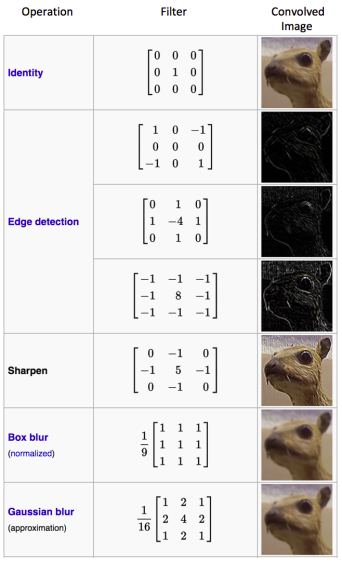

## Now:
Kernels in deep learning networks are used in similar ways, i.e. highlighting some feature. Combined with a system called max pooling, the non-highlighted elements are discarded from each feature map, leaving only the features of interest, reducing the number of learned parameters, and decreasing the computational cost (e.g. system memory). 
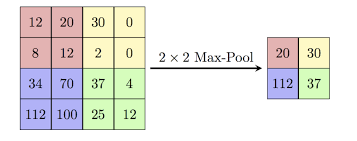

We can also take convolutions of convolutions -- we can stack as many convolutions as we want, as long as there are enough pixels to fit a kernel.

Warning: What you may find down there in those deep convolutions may not appear recognizable to you, see also: https://distill.pub/2019/activation-atlas/

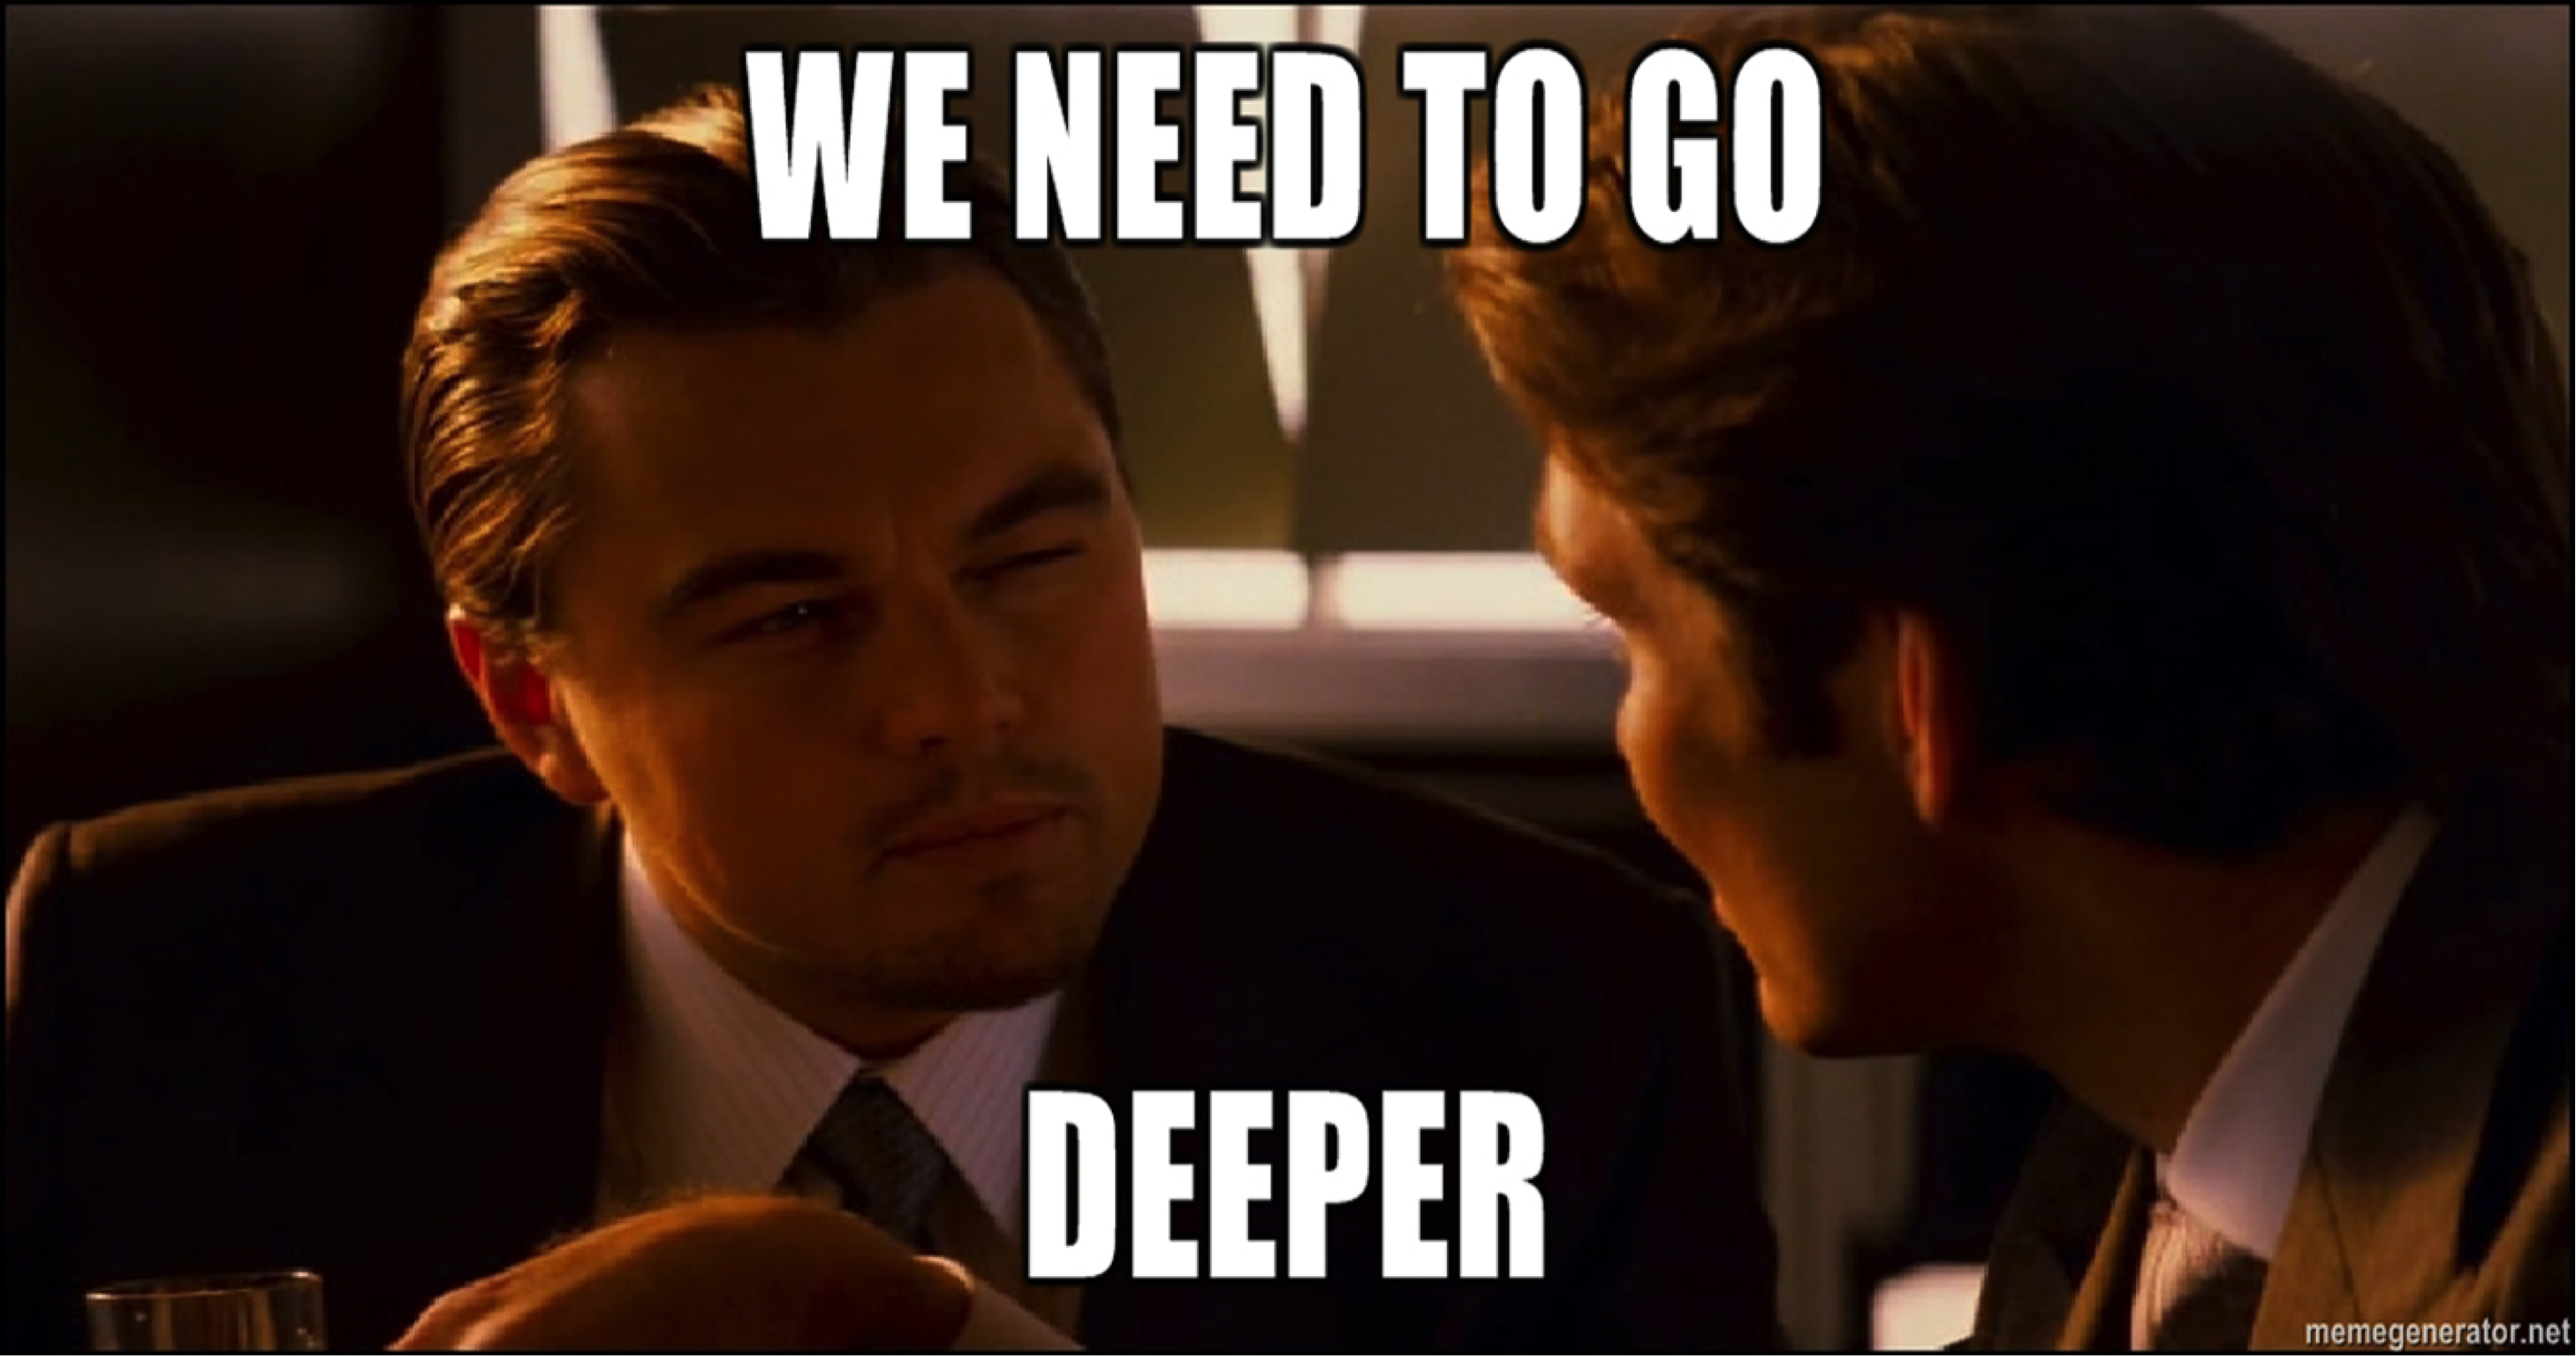

# How to continue?
We will try to classify CIFAR10 with our own CNN, re-using our train/test loops

In [ ]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move data and target to the gpu, if available and used
        data, target = map(lambda tensor: tensor.to(device, non_blocking=True), (data, target))
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        accuracy = metrics.accuracy(output, target)
        
        if batch_idx % log_interval == 0:
            print(
                f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100 * batch_idx / len(train_loader):.0f}%)]'
                f'\tLoss: {loss.detach().item():.6f}'
                f'\tAccuracy: {accuracy.detach().item():.2f}'
            )

        yield loss.detach().item(), accuracy.detach().item() 


@torch.no_grad()
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    for data, target in test_loader:
        # move data and target to the gpu, if available and used
        data, target = map(lambda tensor: tensor.to(device, non_blocking=True), (data, target))

        # get model output
        output = model(data)

        # calculate loss
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

        # get most likely class label
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # count the number of correct predictions
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))
    
    yield test_loss, correct / len(test_loader.dataset)

### Function to plot train/validation curves

In [3]:
def plot_metric_curve(
    train_metric: Sequence[float], 
    val_metric: Sequence[float],
    n_epochs: int,
    metric_name: str, # Label of the y-axis, e.g. 'Accuracy'
    x_axis_name: str = 'Epoch'
):
    # create values for the x-axis
    train_steps, val_steps = map(
        lambda metric_values: np.linspace(start=0, stop=n_epochs, num=len(metric_values)),
        (train_metric, val_metric)
    )
    
    plt.plot(train_steps, train_metric, label='train')
    plt.plot(val_steps, val_metric, label='validation')
    plt.title(f"{metric_name} vs. {x_axis_name}")
    plt.legend()
    plt.show()

### Function to run training and testing loops

In [4]:
def fit(model, optimizer, n_epochs, device, train_loader, test_loader, log_interval):

    # get the validation loss and accuracy of the untrained model
    start_val_loss, start_val_acc = tuple(test(model, device, test_loader))[0]

    # don't mind the following train/test loop logic too much, if you want to know what's happening, let us know :)
    # normally you would pass a logger to your train/test loops and log the respective metrics there
    (train_loss, train_acc), (val_loss, val_acc) = map(lambda arr: np.asarray(arr).transpose(2,0,1), zip(*[
        (
            [*train(model, device, train_loader, optimizer, epoch, log_interval)],
            [*test(model, device, test_loader)]
        )
        for epoch in range(n_epochs)
    ]))

    # flatten the arrays
    train_loss, train_acc, val_loss, val_acc = map(np.ravel, (train_loss, train_acc, val_loss, val_acc))

    # prepend the validation loss and accuracy of the untrained model
    val_loss, val_acc = (start_val_loss, *val_loss), (start_val_acc, *val_acc)

    plot_metric_curve(train_loss, val_loss, n_epochs, 'Loss')
    plot_metric_curve(train_acc, val_acc, n_epochs, 'Accuracy')

# Defining the model
Moving from a FCNN to a CNN, we split our model in two: a feature extractor and a classifier.  
The classifier will be no different to the FCNN: Some linear layers with a non-linearity in-between.  
The feature extractor will be our convolutional layers, with a downsampling operation after each layer; in our case max-pooling.  
(Which you shouldn't normally use unless you have a very good reason to! Take it from Saint Geoff:
https://mirror2image.wordpress.com/2014/11/11/geoffrey-hinton-on-max-pooling-reddit-ama/) )

In [ ]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 4 convolution layers, with a non-linear activation after each.
        # maxpooling after the activations of the 2nd, 3rd, and 4th conv layers
        # 2 dense layers for classification
        # log_softmax
        #
        # As for the number of channels of each layers, try to experiment!

        self.feature_extractor = nn.Sequential(
            ...
        )

        # in_features of the first layer should be the product of the output shape of your feature extractor!
        # E.g. if the output of your feature extractor has size (batch x 128 x 4 x 4), in_features = 128*4*4=2048
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=..., out_features=...),
            nn.ReLU(),
            nn.Linear(in_features=..., out_features=10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        
        return self.classifier(features)


### PyTorch boilerplate

In [6]:
use_cuda = torch.cuda.is_available()
print(f"CUDA is {'' if use_cuda else 'not '}available")
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
    torch.cuda.set_per_process_memory_fraction(0.22)

cpu_count = len(os.sched_getaffinity(0))

CUDA is available


### Hyperparameter settings and Training

In [ ]:
# We can Re-use our train and test loops

BATCH_SIZE = ...
LEARNING_RATE = ...
EPOCHS = ...

LOGGING_INTERVAL = 10

model = CIFAR10CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # optim.<OPTIMIZER_FLAVOUR>(model.parameters(), lr=LEARNING_RATE)

transform=transforms.Compose([
    transforms.ToTensor(),
    # Normalize the data to 0 mean and 1 standard deviation, now for all channels of RGB
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_loader, test_loader = (
    torch.utils.data.DataLoader(
        datasets.CIFAR10(DATA_PATH, train=train, transform=transform, download=True),
        batch_size=BATCH_SIZE,
        pin_memory=use_cuda,
        shuffle=train,
        num_workers=cpu_count
    )
    for train in (True, False)
)

fit(model, optimizer, EPOCHS, device, train_loader, test_loader, LOGGING_INTERVAL)

### Results
Achieving ~75% validation accuracy with our simple CNN Classifier should be possible, how did you do? Let us know!

- Do you see a difference in train accuracy and validation accuracy?
- How does the difference between training and validation accuracy change over time?

The State-of-the-art is currently 99.5% accuracy! (See https://paperswithcode.com/sota/image-classification-on-cifar-10)

One of the areas of improvement is that our model is still not very deep, modern models usually range from 18-50 layers.
However, after around ~15 layers, you start to run into some issues with information propagation through your model: the gradient of the loss is not able to reach the first few layers of the model.

Checkout https://arxiv.org/pdf/1512.03385.pdf for the seminal paper fixing this issue.

### Next chapter: So we can classify images, but can we also generate new ones? Introducing the VAE 